### Traditional Monte Carlo with Different Simulation Models

GBM Model - Monte Carlo Estimated Asian Option Price: 5.7605, Standard Error: 0.0830


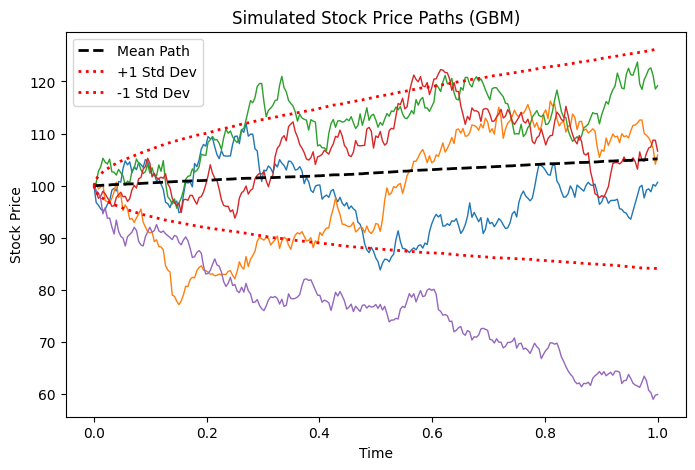

Merton Model - Monte Carlo Estimated Asian Option Price: 5.3333, Standard Error: 0.0973


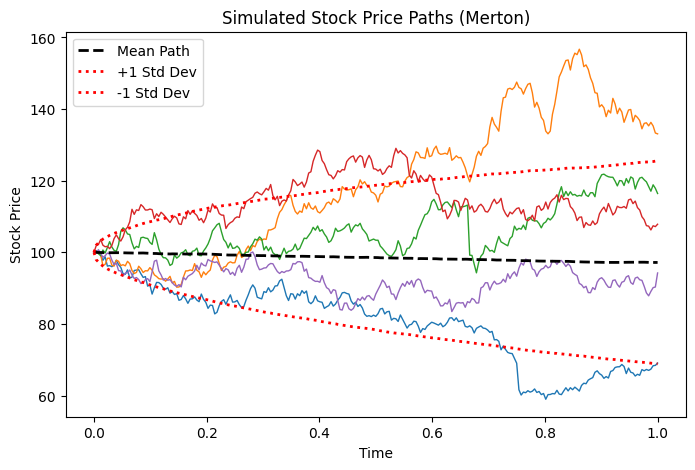

Heston Model - Monte Carlo Estimated Asian Option Price: 5.8179, Standard Error: 0.0846


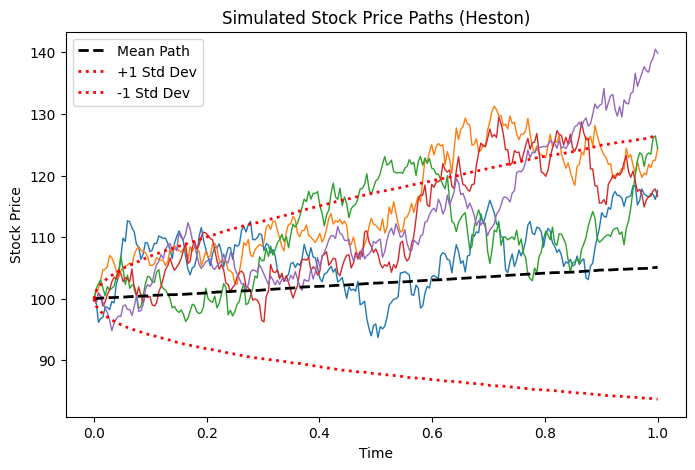

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class MonteCarloOptionPricing:
    def __init__(self, S0, K, T, r, sigma, n_simulations, n_steps, option_type="call", asian=True, model="GBM"):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.n_simulations = n_simulations
        self.n_steps = n_steps
        self.dt = T / n_steps
        self.option_type = option_type
        self.asian = asian
        self.model = model  # Model type: "GBM", "Merton", "Heston"
    
    def simulate_asset_paths(self):
        """Simulates asset price paths using different stochastic models."""
        S = np.zeros((self.n_simulations, self.n_steps + 1))
        S[:, 0] = self.S0  
        Z = np.random.randn(self.n_simulations, self.n_steps)
        
        if self.model == "GBM":
            for t in range(1, self.n_steps + 1):
                S[:, t] = S[:, t-1] * np.exp((self.r - 0.5 * self.sigma**2) * self.dt + 
                                             self.sigma * np.sqrt(self.dt) * Z[:, t-1])
        elif self.model == "Merton":
            lambda_jump = 1.0  # Average jump occurrence per year
            mu_jump = -0.1  # Mean jump size
            sigma_jump = 0.2  # Jump volatility
            
            for t in range(1, self.n_steps + 1):
                N_t = np.random.poisson(lambda_jump * self.dt, self.n_simulations)
                J_t = np.random.normal(mu_jump, sigma_jump, self.n_simulations) * N_t
                S[:, t] = S[:, t-1] * np.exp((self.r - 0.5 * self.sigma**2) * self.dt + 
                                             self.sigma * np.sqrt(self.dt) * Z[:, t-1] + J_t)
        elif self.model == "Heston":
            v0 = self.sigma ** 2  # Initial variance
            kappa = 2.0  # Mean reversion speed
            theta = v0  # Long-run variance
            xi = 0.1  # Volatility of variance
            v = np.full((self.n_simulations, self.n_steps + 1), v0)
            
            for t in range(1, self.n_steps + 1):
                v[:, t] = np.maximum(v[:, t-1] + kappa * (theta - v[:, t-1]) * self.dt +
                                      xi * np.sqrt(v[:, t-1] * self.dt) * np.random.randn(self.n_simulations), 0)
                S[:, t] = S[:, t-1] * np.exp((self.r - 0.5 * v[:, t-1]) * self.dt + 
                                             np.sqrt(v[:, t-1] * self.dt) * Z[:, t-1])
        return S
    
    def calculate_payoff(self, S):
        """Calculates option payoff based on Asian or European option type."""
        if self.asian:
            avg_price = np.mean(S[:, 1:], axis=1)  
        else:
            avg_price = S[:, -1]  
        
        if self.option_type == "call":
            payoff = np.maximum(avg_price - self.K, 0)
        else:
            payoff = np.maximum(self.K - avg_price, 0)
        
        return payoff
    
    def price_option(self):
        """Prices the option using Monte Carlo simulation."""
        S = self.simulate_asset_paths()
        payoff = self.calculate_payoff(S)
        
        option_price = np.exp(-self.r * self.T) * np.mean(payoff)
        std_error = np.std(payoff) / np.sqrt(self.n_simulations)
        
        return option_price, std_error, S
    
    def plot_simulated_paths(self, S):
        """Generates a plot of simulated asset price paths."""
        plt.figure(figsize=(8, 5))
        time_steps = np.linspace(0, self.T, self.n_steps + 1)
        
        for i in range(min(5, self.n_simulations)):
            plt.plot(time_steps, S[i, :], lw=1)
        
        mean_path = np.mean(S, axis=0)
        std_dev = np.std(S, axis=0)
        
        plt.plot(time_steps, mean_path, 'k--', lw=2, label='Mean Path')
        plt.plot(time_steps, mean_path + std_dev, 'r:', lw=2, label='+1 Std Dev')
        plt.plot(time_steps, mean_path - std_dev, 'r:', lw=2, label='-1 Std Dev')
        
        plt.xlabel("Time")
        plt.ylabel("Stock Price")
        plt.title(f"Simulated Stock Price Paths ({self.model})")
        plt.legend()
        plt.show()

# Set parameters
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
n_simulations = 10000
n_steps = 252
option_type = "call"
asian = True

# Test different models
for model in ["GBM", "Merton", "Heston"]:
    mc_pricing = MonteCarloOptionPricing(S0, K, T, r, sigma, n_simulations, n_steps, option_type, asian, model)
    price, std_error, S = mc_pricing.price_option()
    print(f"{model} Model - Monte Carlo Estimated Asian Option Price: {price:.4f}, Standard Error: {std_error:.4f}")
    mc_pricing.plot_simulated_paths(S)


### Traditional Monte Carlo with Different Variance Reduction Techniques

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class MonteCarloOptionPricing:
    def __init__(self, S0, K, T, r, sigma, n_simulations, n_steps, option_type="call", asian=True, model="GBM", variance_reduction=None):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.n_simulations = n_simulations
        self.n_steps = n_steps
        self.dt = T / n_steps
        self.option_type = option_type
        self.asian = asian
        self.model = model  # Model type: "GBM", "Merton", "Heston"
        self.variance_reduction = variance_reduction  # None, "Antithetic", "ControlVariates"
    
    def simulate_asset_paths(self):
        """Simulates asset price paths using different stochastic models."""
        S = np.zeros((self.n_simulations, self.n_steps + 1))
        S[:, 0] = self.S0  
        Z = np.random.randn(self.n_simulations, self.n_steps)
        
        if self.variance_reduction == "Antithetic":
            Z = np.vstack((Z, -Z))  # Generate antithetic variates
            S = np.zeros((2 * self.n_simulations, self.n_steps + 1))
            S[:, 0] = self.S0
        
        for t in range(1, self.n_steps + 1):
            S[:, t] = S[:, t-1] * np.exp((self.r - 0.5 * self.sigma**2) * self.dt + 
                                         self.sigma * np.sqrt(self.dt) * Z[:, t-1])
        
        return S
    
    def calculate_payoff(self, S):
        """Calculates option payoff based on Asian or European option type."""
        if self.asian:
            avg_price = np.mean(S[:, 1:], axis=1)  
        else:
            avg_price = S[:, -1]  
        
        if self.option_type == "call":
            payoff = np.maximum(avg_price - self.K, 0)
        else:
            payoff = np.maximum(self.K - avg_price, 0)
        
        return payoff
    
    def price_option(self):
        """Prices the option using Monte Carlo simulation."""
        S = self.simulate_asset_paths()
        payoff = self.calculate_payoff(S)
        
        if self.variance_reduction == "Antithetic":
            payoff = 0.5 * (payoff[:self.n_simulations] + payoff[self.n_simulations:])
        
        if self.variance_reduction == "ControlVariates":
            GBM_price = self.geometric_asian_option_price()
            control_variate = self.geometric_asian_payoff(S)
            beta = -np.cov(payoff, control_variate)[0, 1] / np.var(control_variate)
            payoff = payoff + beta * (control_variate - GBM_price)
        
        option_price = np.exp(-self.r * self.T) * np.mean(payoff)
        std_error = np.std(payoff) / np.sqrt(self.n_simulations)
        
        return option_price, std_error, S
    
    def geometric_asian_option_price(self):
        """Computes the closed-form price of a geometric Asian option for use in control variates."""
        sigma_adj = self.sigma * np.sqrt((2 * self.n_steps + 1) / (6 * (self.n_steps + 1)))
        mu_adj = self.r - 0.5 * self.sigma**2 + 0.5 * sigma_adj**2
        d1 = (np.log(self.S0 / self.K) + (mu_adj + 0.5 * sigma_adj**2) * self.T) / (sigma_adj * np.sqrt(self.T))
        d2 = d1 - sigma_adj * np.sqrt(self.T)
        if self.option_type == "call":
            return np.exp(-self.r * self.T) * (self.S0 * np.exp(mu_adj * self.T) * norm.cdf(d1) - self.K * norm.cdf(d2))
        else:
            return np.exp(-self.r * self.T) * (self.K * norm.cdf(-d2) - self.S0 * np.exp(mu_adj * self.T) * norm.cdf(-d1))
    
    def geometric_asian_payoff(self, S):
        """Computes the payoff for the geometric Asian option (for control variates)."""
        avg_price = np.exp(np.mean(np.log(S[:, 1:]), axis=1))
        if self.option_type == "call":
            return np.maximum(avg_price - self.K, 0)
        else:
            return np.maximum(self.K - avg_price, 0)
    
# Test different variance reduction techniques
for method in [None, "Antithetic", "ControlVariates"]:
    mc_pricing = MonteCarloOptionPricing(S0=100, K=100, T=1, r=0.05, sigma=0.2, 
                                         n_simulations=10000, n_steps=252, option_type="call", 
                                         asian=True, model="GBM", variance_reduction=method)
    price, std_error, _ = mc_pricing.price_option()
    print(f"Variance Reduction: {method} - Price: {price:.4f}, Std Error: {std_error:.4f}")


Variance Reduction: None - Price: 5.8756, Std Error: 0.0857
Variance Reduction: Antithetic - Price: 5.7591, Std Error: 0.0411
Variance Reduction: ControlVariates - Price: 6.3762, Std Error: 0.0022
